# Outlier Example

![architecture](architecture.png)

In this example we will:

  * [Describe the project structure](#Project-Structure)
  * [Train some models](#Train-Models)
  * [Create Tempo artifacts](#Create-Tempo-Artifacts)
  * [Run unit tests](#Unit-Tests)
  * [Save python environment for our classifier](#Save-Classifier-Environment)
  * [Test Locally on Docker](#Test-Locally-on-Docker)
  * [Production on Kubernetes via Tempo](#Production-Option-1-(Deploy-to-Kubernetes-with-Tempo))
  * [Prodiuction on Kuebrnetes via GitOps](#Production-Option-2-(Gitops))

## Prerequisites

This notebooks needs to be run in the `tempo-examples` conda environment defined below. Create from project root folder:

```bash
conda env create --name tempo-examples --file conda/tempo-examples.yaml
```

## Project Structure

In [1]:
!tree -P "*.py"  -I "__init__.py|__pycache__" -L 2

.
├── artifacts
│   ├── model
│   ├── outlier
│   └── svc
├── k8s
│   └── rbac
├── README_files
├── src
│   ├── constants.py
│   ├── data.py
│   ├── outlier.py
│   ├── tempo.py
│   └── utils.py
└── tests
    └── test_tempo.py

9 directories, 6 files


## Train Models

 * This section is where as a data scientist you do your work of training models and creating artfacts.
 * For this example we train sklearn and xgboost classification models for the iris dataset.

In [2]:
import os
import logging
import numpy as np
import tempo

from tempo.utils import logger
from src.constants import ARTIFACTS_FOLDER

logger.setLevel(logging.ERROR)
logging.basicConfig(level=logging.ERROR)

In [3]:
from src.data import Cifar10
data = Cifar10()

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


Download pretrained Resnet32 Tensorflow model for CIFAR10

In [4]:
!rclone --config ./rclone-gcs.conf copy gs://seldon-models/tfserving/cifar10/resnet32 ./artifacts/model

Download or train an outlier detector on CIFAR10 data

In [5]:
load_pretrained = True
if load_pretrained:  # load pre-trained detector
    !rclone --config ./rclone-gcs.conf copy gs://seldon-models/tempo/cifar10/outlier/cifar10 ./artifacts/outlier/cifar10
else:
    from src.outlier import train_outlier_detector
    train_outlier_detector(data, ARTIFACTS_FOLDER)

## Create Tempo Artifacts


In [6]:
from src.tempo import create_outlier_cls, create_model, create_svc_cls

cifar10_model = create_model()
OutlierModel = create_outlier_cls()
outlier = OutlierModel()
Cifar10Svc = create_svc_cls(outlier, cifar10_model)
svc = Cifar10Svc()

Loading from /home/clive/work/mlops/fork-tempo/docs/examples/outlier/artifacts/outlier


In [7]:
# %load src/tempo.py
import json
import os

import numpy as np
from alibi_detect.base import NumpyEncoder
from src.constants import ARTIFACTS_FOLDER, MODEL_FOLDER, OUTLIER_FOLDER

from tempo.kfserving.protocol import KFServingV1Protocol, KFServingV2Protocol
from tempo.serve.metadata import ModelFramework
from tempo.serve.model import Model
from tempo.serve.pipeline import PipelineModels
from tempo.serve.utils import model, pipeline, predictmethod


def create_outlier_cls():
    @model(
        name="outlier",
        platform=ModelFramework.Custom,
        protocol=KFServingV2Protocol(),
        uri="s3://tempo/outlier/cifar10/outlier",
        local_folder=os.path.join(ARTIFACTS_FOLDER, OUTLIER_FOLDER),
    )
    class OutlierModel(object):
        def __init__(self):
            from alibi_detect.utils.saving import load_detector

            model = self.get_tempo()
            models_folder = model.details.local_folder
            print(f"Loading from {models_folder}")
            self.od = load_detector(os.path.join(models_folder, "cifar10"))

        @predictmethod
        def outlier(self, payload: np.ndarray) -> dict:
            od_preds = self.od.predict(
                payload,
                outlier_type="instance",  # use 'feature' or 'instance' level
                return_feature_score=True,
                # scores used to determine outliers
                return_instance_score=True,
            )

            return json.loads(json.dumps(od_preds, cls=NumpyEncoder))

    return OutlierModel


def create_model():

    cifar10_model = Model(
        name="resnet32",
        protocol=KFServingV1Protocol(),
        platform=ModelFramework.Tensorflow,
        uri="gs://seldon-models/tfserving/cifar10/resnet32",
        local_folder=os.path.join(ARTIFACTS_FOLDER, MODEL_FOLDER),
    )

    return cifar10_model


def create_svc_cls(outlier, model):
    @pipeline(
        name="cifar10-service",
        protocol=KFServingV2Protocol(),
        uri="s3://tempo/outlier/cifar10/svc",
        local_folder=os.path.join(ARTIFACTS_FOLDER, "svc"),
        models=PipelineModels(outlier=outlier, cifar10=model),
    )
    class Cifar10Svc(object):
        @predictmethod
        def predict(self, payload: np.ndarray) -> np.ndarray:
            r = self.models.outlier(payload=payload)
            if r["data"]["is_outlier"][0]:
                return np.array([])
            else:
                return self.models.cifar10(payload)

    return Cifar10Svc


## Unit Tests

 * Here we run our unit tests to ensure the orchestration works before running on the actual models.

In [8]:
# %load tests/test_tempo.py
import numpy as np
from src.tempo import create_model, create_outlier_cls, create_svc_cls


def test_svc_outlier():
    model = create_model()
    OutlierModel = create_outlier_cls()
    outlier = OutlierModel()
    Cifar10Svc = create_svc_cls(outlier, model)
    svc = Cifar10Svc()
    svc.models.outlier = lambda payload: {"data": {"is_outlier": [1]}}
    svc.models.cifar10 = lambda input: np.array([[0.2]])
    res = svc(np.array([1]))
    assert res.shape[0] == 0


def test_svc_inlier():
    model = create_model()
    OutlierModel = create_outlier_cls()
    outlier = OutlierModel()
    Cifar10Svc = create_svc_cls(outlier, model)
    svc = Cifar10Svc()
    svc.models.outlier = lambda payload: {"data": {"is_outlier": [0]}}
    svc.models.cifar10 = lambda input: np.array([[0.2]])
    res = svc(np.array([1]))
    assert res.shape[0] == 1


In [9]:
!python -m pytest tests/

============================= test session starts ==============================
platform linux -- Python 3.7.9, pytest-6.2.0, py-1.10.0, pluggy-0.13.1
rootdir: /home/clive/work/mlops/fork-tempo, configfile: setup.cfg
plugins: cases-3.4.6, asyncio-0.14.0
collected 2 items                                                              

tests/test_tempo.py ..                                                   [100%]

=============================== warnings summary ===============================
../../../../../../anaconda3/envs/tempo-examples/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:22
  /home/clive/anaconda3/envs/tempo-examples/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
    import imp

../../../../../../anaconda3/envs/tempo-examples/lib/python3.7/site-packages/packaging/version.py:130
  /home/clive/anaconda3/e

## Save Outlier and Svc Environments


In [10]:
tempo.save(OutlierModel)

Packing environment at '/home/clive/anaconda3/envs/tempo-c08c4322-62be-4461-82bc-d69ae2432671' to '/home/clive/work/mlops/fork-tempo/docs/examples/outlier/artifacts/outlier/environment.tar.gz'
[########################################] | 100% Completed |  1min  9.5s


In [11]:
tempo.save(Cifar10Svc)

Packing environment at '/home/clive/anaconda3/envs/tempo-27f221b3-8635-4b7e-ace6-443f6d7e3b15' to '/home/clive/work/mlops/fork-tempo/docs/examples/outlier/artifacts/svc/environment.tar.gz'
[########################################] | 100% Completed | 11.5s


## Test Locally on Docker

Here we test our models using production images but running locally on Docker. This allows us to ensure the final production deployed model will behave as expected when deployed.

In [12]:
from tempo import deploy_local
remote_model = deploy_local(svc)

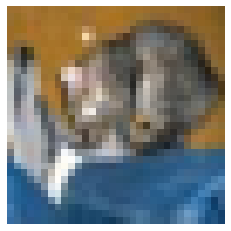

array([[3.92254496e-09, 1.20455460e-11, 2.66011191e-09, 9.99992609e-01,
        2.52213306e-10, 5.40860242e-07, 6.75954425e-06, 4.75119076e-12,
        6.90874735e-09, 1.07275586e-11]])

In [14]:
from src.utils import show_image
show_image(data.X_test[0:1])
remote_model.predict(payload=data.X_test[0:1])

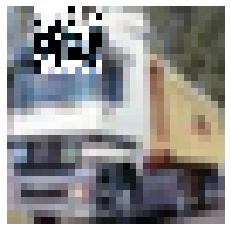

array([], dtype=float64)

In [15]:
from src.utils import create_cifar10_outlier

outlier_img = create_cifar10_outlier(data)
show_image(outlier_img)
remote_model.predict(payload=outlier_img)

In [16]:
remote_model.undeploy()

## Production Option 1 (Deploy to Kubernetes with Tempo)

 * Here we illustrate how to run the final models in "production" on Kubernetes by using Tempo to deploy
 
### Prerequisites
 
Create a Kind Kubernetes cluster with Minio and Seldon Core installed using Ansible as described [here](https://tempo.readthedocs.io/en/latest/overview/quickstart.html#kubernetes-cluster-with-seldon-core).

In [17]:
!kubectl apply -f k8s/rbac -n production

secret/minio-secret configured
serviceaccount/tempo-pipeline unchanged
role.rbac.authorization.k8s.io/tempo-pipeline unchanged
rolebinding.rbac.authorization.k8s.io/tempo-pipeline-rolebinding unchanged


In [18]:
from tempo.examples.minio import create_minio_rclone
import os

create_minio_rclone(os.getcwd()+"/rclone-minio.conf")

In [19]:
tempo.upload(cifar10_model)
tempo.upload(outlier)
tempo.upload(svc)

In [20]:
from tempo.serve.metadata import SeldonCoreOptions
runtime_options = SeldonCoreOptions(**{
        "remote_options": {
            "namespace": "production",
            "authSecretName": "minio-secret"
        }
    })

In [21]:
from tempo import deploy_remote
remote_model = deploy_remote(svc, options=runtime_options)

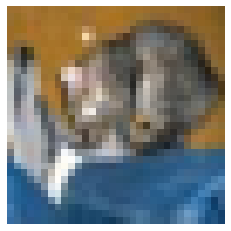

array([[3.92254496e-09, 1.20455460e-11, 2.66011191e-09, 9.99992609e-01,
        2.52213306e-10, 5.40860242e-07, 6.75954425e-06, 4.75119076e-12,
        6.90874735e-09, 1.07275586e-11]])

In [22]:
from src.utils import show_image

show_image(data.X_test[0:1])
remote_model.predict(payload=data.X_test[0:1])

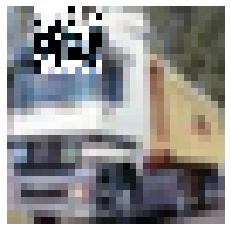

array([], dtype=float64)

In [23]:
from src.utils import create_cifar10_outlier

outlier_img = create_cifar10_outlier(data)
show_image(outlier_img)
remote_model.predict(payload=outlier_img)

In [24]:
remote_model.undeploy()

## Production Option 2 (Gitops)

 * We create yaml to provide to our DevOps team to deploy to a production cluster
 * We add Kustomize patches to modify the base Kubernetes yaml created by Tempo

In [7]:
from tempo import manifest
from tempo.serve.metadata import SeldonCoreOptions
runtime_options = SeldonCoreOptions(**{
        "remote_options": {
            "namespace": "production",
            "authSecretName": "minio-secret"
        }
    })
yaml_str = manifest(svc, options=runtime_options)
with open(os.getcwd()+"/k8s/tempo.yaml","w") as f:
    f.write(yaml_str)

In [8]:
!kustomize build k8s

apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  annotations:
    seldon.io/tempo-description: ""
    seldon.io/tempo-model: '{"model_details": {"name": "cifar10-service", "local_folder":
      "/home/clive/work/mlops/fork-tempo/docs/examples/outlier/artifacts/svc", "uri":
      "s3://tempo/outlier/cifar10/svc", "platform": "tempo", "inputs": {"args": [{"ty":
      "numpy.ndarray", "name": "payload"}]}, "outputs": {"args": [{"ty": "numpy.ndarray",
      "name": null}]}, "description": ""}, "protocol": "tempo.kfserving.protocol.KFServingV2Protocol",
      "runtime_options": {"runtime": "tempo.seldon.SeldonKubernetesRuntime", "state_options":
      {"state_type": "LOCAL", "key_prefix": "", "host": "", "port": ""}, "insights_options":
      {"worker_endpoint": "", "batch_size": 1, "parallelism": 1, "retries": 3, "window_time":
      0, "mode_type": "NONE", "in_asyncio": false}, "ingress_options": {"ingress":
      "tempo.ingress.istio.IstioIngress", "ssl": false